# Peak calling DL model

## Setup

### Create an environment

#### Run these commands in your terminal while in the project directory and select the 'DL_peak_calling' kernel

```
conda create -n DL_peak_calling -c conda-forge mamba python=3.9 -y
conda activate DL_peak_calling
mamba env update --file environment.yml
```

### Import and configure libraries

In [1]:
import os
import pickle
import json
from time import gmtime, strftime
from collections import Counter
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import torch.multiprocessing as mp
from Bio import SeqIO
from ray.tune import ExperimentAnalysis


import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams.update({'font.size': 14})
# Uncomment to use dark plots
# plt.style.use('dark_background')
import seaborn as sns

from tqdm.notebook import tqdm

INDIGO = '#4B0082'
LAVENDER = '#F0CCFF'

2024-10-04 15:51:52,366	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.4 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-04 15:51:52,778	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.4 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Set a number of workers

In [2]:
# Specify instead of 'None' if necessary
num_workers = None

if not num_workers:
    num_workers = cpu_count()

num_workers

96

## Retrieve the data

#### Retrieve the [dyad positions](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE97290)

In [3]:
%%bash


for i in 1 2 3
do
    mkdir ../data/dataset_${i} -p

    wget \
        https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM256105$((i+6))/suppl/GSM256105$((i+6))%5FDyads%5FH3%5FCC%5Frep%5F${i}%2Ebw \
        -O ../data/dataset_${i}/dyads.bw \
        --no-verbose \
        2>&1
done

2024-08-23 09:53:44 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561057/suppl/GSM2561057%5FDyads%5FH3%5FCC%5Frep%5F1%2Ebw [10064746/10064746] -> "../data/dataset_1/dyads.bw" [1]
2024-08-23 09:53:48 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561058/suppl/GSM2561058%5FDyads%5FH3%5FCC%5Frep%5F2%2Ebw [8556133/8556133] -> "../data/dataset_2/dyads.bw" [1]
2024-08-23 09:53:51 URL:https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM2561nnn/GSM2561059/suppl/GSM2561059%5FDyads%5FH3%5FCC%5Frep%5F3%2Ebw [7220516/7220516] -> "../data/dataset_3/dyads.bw" [1]


#### Convert .bw dyad positions to .bed, removing the first non-informative line

In [4]:
%%bash

for i in 1 2 3
do
    bigWigToBedGraph ../data/dataset_${i}/dyads.bw ../data/dataset_${i}/dyads.bed

    sed 1d ../data/dataset_${i}/dyads.bed > ../data/dataset_${i}/dyads_tmp.bed

    mv ../data/dataset_${i}/dyads_tmp.bed ../data/dataset_${i}/dyads.bed
done

head -n 5 ../data/dataset_1/dyads.bed

chrI	32	33	2.572
chrI	33	38	0
chrI	38	39	7.715
chrI	39	66	0
chrI	66	67	12.859


#### Retrieve the [S. cerevisiae (sacCer3) reference genome](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000146045.2/)

In [5]:
%%bash


wget \
    https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz \
    -O ../data/reference_genome.fasta.gz \
    --no-verbose \
    2>&1

gunzip \
    ../data/reference_genome.fasta.gz \
    --force

2024-08-23 09:54:00 URL:https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz [3843460/3843460] -> "../data/reference_genome.fasta.gz" [1]


## Prepare the data

### Extract dyad positions

#### Load the dyad positions

In [6]:
def load_dyad_positions(dataset_number):
    raw_dyad_positions = pd.read_csv(
        os.path.join('..', 'data', f'dataset_{dataset_number}', 'dyads.bed'),
        sep='\t',
        usecols=[0, 2, 3],
        names=['chr', 'dyad_pos', 'signal']
    )
    return raw_dyad_positions


raw_dyad_positions_1 = load_dyad_positions(1)
raw_dyad_positions_2 = load_dyad_positions(2)
raw_dyad_positions_3 = load_dyad_positions(3)

raw_dyad_positions_1

,chr,dyad_pos,signal
0,chrI,33,2.572
1,chrI,38,0.000
2,chrI,39,7.715
3,chrI,66,0.000
4,chrI,67,12.859
...,...,...,...
3383780,chrXVI,948031,0.000
3383781,chrXVI,948032,7.568
3383782,chrXVI,948034,0.000
3383783,chrXVI,948035,5.046


#### Look at signal probability distributions

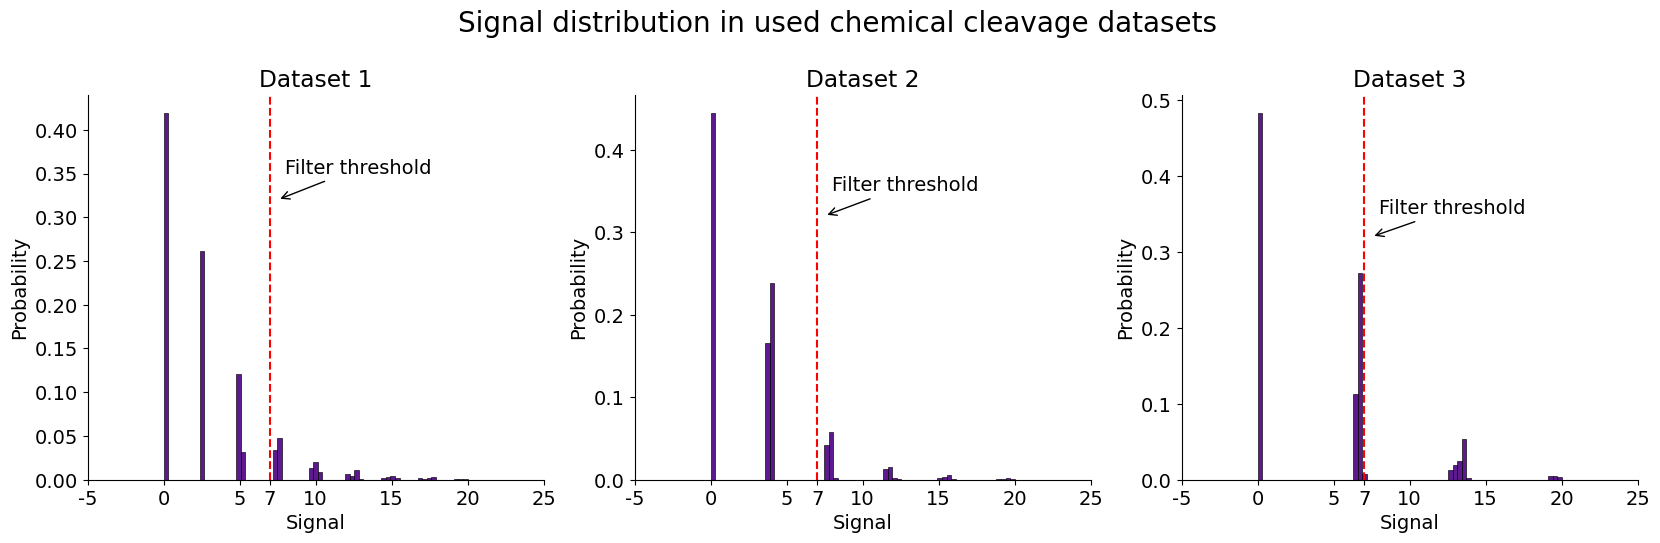

In [175]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(3):
    sns.histplot(
        eval(f'raw_dyad_positions_{i+1}.signal'),
        binwidth=0.3,
        binrange=(0, 20),
        color=INDIGO,
        alpha=0.9,
        stat='probability',
        ax=ax[i]
    )
    
    # Add a threshold tick label
    current_ticks = ax[i].get_xticks()
    threshold = 7
    all_ticks = list(current_ticks) + [threshold]
    ax[i].set_xticks(all_ticks)
    ax[i].set_xticklabels([str(int(tick)) if tick != new_tick else str(threshold) for tick in all_ticks])
    
    # Add a threshold line
    ax[i].axvline(
        x=threshold,
        color='red',
        linestyle='--'
    )
    ax[i].annotate(
        'Filter threshold',
        xy=(7.5, 0.32),
        xytext=(8, 0.35),
        arrowprops=dict(facecolor='black', arrowstyle='->')
    )

    ax[i].set_title(f'Dataset {i+1}')
    ax[i].set_xlabel('Signal')
    ax[i].set_ylabel('Probability')
    ax[i].spines[['right', 'top']].set_visible(False)

fig.suptitle(
    'Signal distribution in used chemical cleavage datasets',
    fontsize=20,
    y=1.05
)

plt.show()

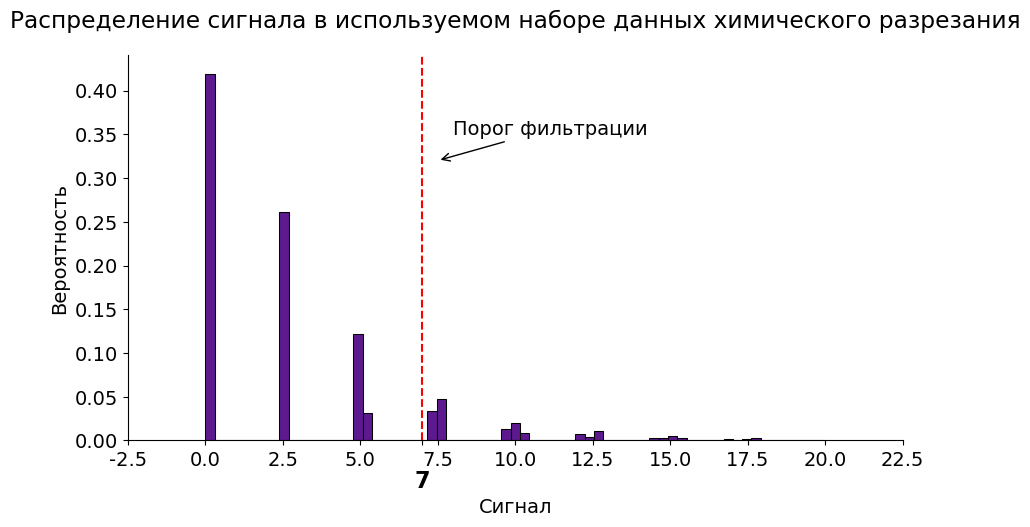

In [248]:
# Cell used in diploma

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(
    raw_dyad_positions_1.signal,
    binwidth=0.3,
    binrange=(0, 20),
    color=INDIGO,
    alpha=0.9,
    stat='probability'
)

# Add a threshold tick label
current_ticks = ax.get_xticks()
threshold = 7
all_ticks = list(current_ticks) + [threshold]
ax.set_xticks(all_ticks)
ax.set_xticklabels([str(tick) for tick in all_ticks])
for label in ax.get_xticklabels():
    if label.get_text() == str(threshold):
        label.set_fontproperties(FontProperties(weight='bold', size=16))
        label.set_y(-0.05)

# Add a threshold line
ax.axvline(
    x=threshold,
    color='red',
    linestyle='--'
)
ax.annotate(
    'Порог фильтрации',
    xy=(7.5, 0.32),
    xytext=(8, 0.35),
    arrowprops=dict(facecolor='black', arrowstyle='->')
)

ax.set_title(
    'Распределение сигнала в используемом наборе данных химического разрезания',
    y=1.05
)
ax.set_xlabel('Сигнал')
ax.set_ylabel('Вероятность')
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('../signal_dist.png', dpi=300, bbox_inches='tight')

plt.show()

#### Filter rows with low signal

In [8]:
def filter_rows_wo_signal(raw_dyad_positions):
    dyad_positions = raw_dyad_positions \
        .query('signal > 7') \
        .drop('signal', axis=1) \
        .reset_index(drop=True)
    return dyad_positions


dyad_positions_1 = filter_rows_wo_signal(raw_dyad_positions_1)
dyad_positions_2 = filter_rows_wo_signal(raw_dyad_positions_2)
dyad_positions_3 = filter_rows_wo_signal(raw_dyad_positions_3)

dyad_positions_1

,chr,dyad_pos
0,chrI,39
1,chrI,67
2,chrI,94
3,chrI,100
4,chrI,129
...,...,...
594211,chrXVI,947724
594212,chrXVI,947817
594213,chrXVI,947840
594214,chrXVI,948030


### Calculate template positions

#### Load the dyad probability distributions dictionary

In [9]:
with open(os.path.join('..', 'data', 'exo_dyad_dists.json')) as file:
    exo_dyad_dist_lists = json.load(file)

exo_dyad_dists = {int(key): np.array(value) for key, value in exo_dyad_dist_lists.items()}

exo_dyad_dists[200]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

#### Calculate template positions

In [10]:
def get_template_position(dyad_pos):
    # Get random dyad position in the internal tempalte's reference frame
    internal_dyad_pos= np.random.choice(
        np.arange(1, 201),
        p=list(exo_dyad_dists[200])
    )
    
    # Calculate template's boundaries
    start_pos = dyad_pos - internal_dyad_pos - 1
    stop_pos = start_pos + 200
    
    return start_pos, internal_dyad_pos, stop_pos


def calc_template_positions(dyad_positions):
    with Pool(num_workers) as pool:
        iterator = pool.imap(get_template_position, dyad_positions['dyad_pos'])
        result = np.array(list(tqdm(
            iterator,
            total=len(dyad_positions),
            colour=INDIGO
        )))
    
    template_positions = dyad_positions.assign(
        start_pos=result[:, 0],
        internal_dyad_pos=result[:, 1],
        stop_pos=result[:, 2]
    )

    return template_positions


template_positions_1 = calc_template_positions(dyad_positions_1)
template_positions_2 = calc_template_positions(dyad_positions_2)
template_positions_3 = calc_template_positions(dyad_positions_3)

template_positions_1

  0%|          | 0/594216 [00:00<?, ?it/s]

  0%|          | 0/506830 [00:00<?, ?it/s]

  0%|          | 0/323248 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,39,-63,101,137
1,chrI,67,-35,101,165
2,chrI,94,-8,101,192
3,chrI,100,-2,101,198
4,chrI,129,27,101,227
...,...,...,...,...,...
594211,chrXVI,947724,947622,101,947822
594212,chrXVI,947817,947715,101,947915
594213,chrXVI,947840,947738,101,947938
594214,chrXVI,948030,947928,101,948128


#### Filter template positions to be inside the reference genome

In [11]:
def filter_max_stop_positions(template_positions):
    max_positions = template_positions.groupby('chr')['stop_pos'].max() - 200
    
    filtered_template_positions = pd.merge(
        template_positions,
        max_positions,
        on='chr',
        suffixes=('', '_max')
    )
    filtered_template_positions = filtered_template_positions \
        .query('(start_pos > 0) & (stop_pos < stop_pos_max)') \
        .drop('stop_pos_max', axis=1) \
        .reset_index(drop=True)
    
    return filtered_template_positions

filtered_template_positions_1 = filter_max_stop_positions(template_positions_1)
filtered_template_positions_2 = filter_max_stop_positions(template_positions_2)
filtered_template_positions_3 = filter_max_stop_positions(template_positions_3)

filtered_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,chrI,129,27,101,227
1,chrI,133,31,101,231
2,chrI,135,33,101,233
3,chrI,139,37,101,237
4,chrI,146,44,101,244
...,...,...,...,...,...
593999,chrXVI,947720,947618,101,947818
594000,chrXVI,947721,947620,100,947820
594001,chrXVI,947722,947621,100,947821
594002,chrXVI,947724,947622,101,947822


#### Calculate collateral dyad positions

In [12]:
def calc_collateral_dyad_positions(template_positions):
    template_positions['dyad_pos'] = template_positions['dyad_pos'].astype('int32')
    template_positions['chr'] = template_positions['chr'].astype('category')

    def get_internal_positions(row):
        query = f'dyad_pos >= {row.start_pos} and dyad_pos <= {row.stop_pos} and chr == "{row.chr}"'
        internal_dyad_positions = template_positions.query(query)['dyad_pos'] - row.start_pos - 1
        internal_dyad_positions = internal_dyad_positions.tolist()
        
        return internal_dyad_positions
    
    tqdm.pandas(colour=INDIGO)
    internal_dyad_positions = template_positions.progress_apply(get_internal_positions, axis=1)
    
    multilabel_template_positions = template_positions \
        .copy() \
        .rename(columns={'internal_dyad_pos': 'internal_dyad_positions'})
    multilabel_template_positions['internal_dyad_positions'] = internal_dyad_positions

    return multilabel_template_positions


multilabel_template_positions_1 = calc_collateral_dyad_positions(filtered_template_positions_1)
multilabel_template_positions_2 = calc_collateral_dyad_positions(filtered_template_positions_2)
multilabel_template_positions_3 = calc_collateral_dyad_positions(filtered_template_positions_3)

multilabel_template_positions_1

  0%|          | 0/594004 [00:00<?, ?it/s]

  0%|          | 0/506700 [00:00<?, ?it/s]

  0%|          | 0/322808 [00:00<?, ?it/s]

,chr,dyad_pos,start_pos,internal_dyad_positions,stop_pos
0,chrI,129,27,"[101, 105, 107, 111, 118, 124, 137, 176, 186, ...",227
1,chrI,133,31,"[97, 101, 103, 107, 114, 120, 133, 172, 182, 1...",231
2,chrI,135,33,"[95, 99, 101, 105, 112, 118, 131, 170, 180, 18...",233
3,chrI,139,37,"[91, 95, 97, 101, 108, 114, 127, 166, 176, 182...",237
4,chrI,146,44,"[84, 88, 90, 94, 101, 107, 120, 159, 169, 175,...",244
...,...,...,...,...,...
593999,chrXVI,947720,947618,"[20, 77, 80, 85, 92, 93, 99, 100, 101, 102, 10...",947818
594000,chrXVI,947721,947620,"[18, 75, 78, 83, 90, 91, 97, 98, 99, 100, 101,...",947820
594001,chrXVI,947722,947621,"[17, 74, 77, 82, 89, 90, 96, 97, 98, 99, 100, ...",947821
594002,chrXVI,947724,947622,"[16, 73, 76, 81, 88, 89, 95, 96, 97, 98, 99, 1...",947822


#### Cache the dyad positions

In [13]:
def cache_dyad_positions(dataset_number):
    cache_path = os.path.join('..', 'data', f'dataset_{dataset_number}', 'cache')
    
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
        
    with open(os.path.join(cache_path, 'internal_dyad_positions.pickle'), 'wb') as file:
        pickle.dump(eval(f'multilabel_template_positions_{dataset_number}.internal_dyad_positions'), file)


cache_dyad_positions(1)
cache_dyad_positions(2)
cache_dyad_positions(3)

### Get template sequences based on the template positions

#### Substitute 'chr' column values with NCBI identifiers

In [14]:
# Make a dictionary manually using NCBI data
chr_to_id = {
    'chrI': 'NC_001133.9',
    'chrII': 'NC_001134.8',
    'chrIII': 'NC_001135.5',
    'chrIV': 'NC_001136.10',
    'chrV': 'NC_001137.3',
    'chrVI': 'NC_001138.5',
    'chrVII': 'NC_001139.9',
    'chrVIII': 'NC_001140.6',
    'chrIX': 'NC_001141.2',
    'chrX': 'NC_001142.9',
    'chrXI': 'NC_001143.9',
    'chrXII': 'NC_001144.5',
    'chrXIII': 'NC_001145.3',
    'chrXIV': 'NC_001146.8',
    'chrXV': 'NC_001147.6',
    'chrXVI': 'NC_001148.4'
}


def convert_chr_to_id(template_positions):
    template_positions['chr'] = template_positions['chr'].cat.rename_categories(chr_to_id)
    
    return template_positions


renamed_template_positions_1 = convert_chr_to_id(filtered_template_positions_1)
renamed_template_positions_2 = convert_chr_to_id(filtered_template_positions_2)
renamed_template_positions_3 = convert_chr_to_id(filtered_template_positions_3)

renamed_template_positions_1

,chr,dyad_pos,start_pos,internal_dyad_pos,stop_pos
0,NC_001133.9,129,27,101,227
1,NC_001133.9,133,31,101,231
2,NC_001133.9,135,33,101,233
3,NC_001133.9,139,37,101,237
4,NC_001133.9,146,44,101,244
...,...,...,...,...,...
593999,NC_001148.4,947720,947618,101,947818
594000,NC_001148.4,947721,947620,100,947820
594001,NC_001148.4,947722,947621,100,947821
594002,NC_001148.4,947724,947622,101,947822


#### Load template positions into a bedGraph file

In [15]:
def templates_to_bedgraph(renamed_template_positions, dataset_number):
    renamed_template_positions[['chr', 'start_pos', 'stop_pos']].to_csv(
        os.path.join('..', 'data', f'dataset_{dataset_number}', 'templates.bed'),
        sep='\t',
        index=False,
        header=False
    )


templates_to_bedgraph(renamed_template_positions_1, 1)
templates_to_bedgraph(renamed_template_positions_2, 2)
templates_to_bedgraph(renamed_template_positions_3, 3)

! head -n 5 ../data/dataset_1/templates.bed

NC_001133.9	27	227
NC_001133.9	31	231
NC_001133.9	33	233
NC_001133.9	37	237
NC_001133.9	44	244


#### Extract sequences from a FASTA file based on positions in bedGraph file

In [16]:
%%bash

for i in 1 2 3
do
    bedtools getfasta \
        -fi ../data/reference_genome.fasta \
        -bed ../data/dataset_${i}/templates.bed \
        -fo ../data/dataset_${i}/templates.fasta
done

rm ../data/reference_genome.fasta.fai

head -n 5 ../data/dataset_1/templates.fasta

>NC_001133.9:27-227
cacaccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCC
>NC_001133.9:31-231
ccacacaccacaccacacccacacacacacatCCTAACACTACCCTAACACAGCCCTAATCTAACCCTGGCCAACCTGTCTCTCAACTTACCCTCCATTACCCTGCCTCCACTCGTTACCCTGTCCCATTCAACCATACCACTCCGAACCACCATCCATCCCTCTACTTACTACCACTCACCCACCGTTACCCTCCAATT
>NC_001133.9:33-233


#### Parse the FASTA file

In [24]:
def parse_fasta_templates(dataset_number):
    fasta_path = os.path.join('..', 'data', f'dataset_{dataset_number}', 'templates.fasta')
    fasta_templates = SeqIO.parse(fasta_path, 'fasta')

    templates = list(
        map(
            lambda record: list(str(record.seq).upper()),
            fasta_templates
        )
    )
    
    return templates


templates_1 = parse_fasta_templates(1)
templates_2 = parse_fasta_templates(2)
templates_3 = parse_fasta_templates(3)

print(templates_1[0])

['C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'A', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'C', 'A', 'T', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'T', 'A', 'C', 'C', 'C', 'T', 'A', 'A', 'C', 'A', 'C', 'A', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'T', 'C', 'T', 'A', 'A', 'C', 'C', 'C', 'T', 'G', 'G', 'C', 'C', 'A', 'A', 'C', 'C', 'T', 'G', 'T', 'C', 'T', 'C', 'T', 'C', 'A', 'A', 'C', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C', 'A', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'C', 'C', 'T', 'C', 'C', 'A', 'C', 'T', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'G', 'T', 'C', 'C', 'C', 'A', 'T', 'T', 'C', 'A', 'A', 'C', 'C', 'A', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'C', 'G', 'A', 'A', 'C', 'C', 'A', 'C', 'C', 'A', 'T', 'C', 'C', 'A', 'T', 'C', 'C', 'C', 'T', 'C', 'T', 'A', 'C', 'T', 'T', 'A', 'C', 'T', 'A', 'C', 'C', 'A', 'C', 'T', 'C', 'A', 'C', 'C', 'C', 'A', 'C', 'C', 'G', 'T', 'T', 'A', 'C', 'C', 'C', 'T', 'C', 'C']

#### Cache the templates

In [26]:
def cache_templates(dataset_number):
    cache_path = os.path.join('..', 'data', f'dataset_{dataset_number}', 'cache', 'templates.pickle')
    with open(cache_path, 'wb') as file:
        pickle.dump(eval(f'templates_{dataset_number}'), file)


cache_templates(1)
cache_templates(2)
cache_templates(3)

## Train the model

### Set up hyperparameters

In [7]:
%%writefile config.py
from ray.tune import grid_search

RUN_NAME = 'test'

config = {
    # Model hyperparameters
    'HIDDEN_SIZE': 256,
    'NUM_LAYERS': 1,
    'LR': 1e-3,
    'WEIGHT_DECAY': 1e-6,

    # Dataset hyperparameters
    'DATASET_NUMBER': 1,
    'K': 3,
    'BATCH_SIZE': 2048,
    'NUM_WORKERS': 16,
}

Overwriting config.py


In [8]:
%run config.py

### Run the following commands in the terminal while in this directory

```
conda activate DL_peak_calling
python train.py
```

### Show results

#### Define a dashboard function

In [19]:
# Cell used in diploma
def show_dashboard(run_name):
    # Extract history values
    history = pd.read_csv(os.path.join('..', 'results', run_name, 'progress.csv'))
    
    train_loss = history['train_loss'].dropna().values
    val_loss = history['val_loss'].dropna().values
    train_f1 = history['train_f1'].dropna().values
    val_f1 = history['val_f1'].dropna().values
    
    # Set up axes
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplot_mosaic(
        [['top_left', 'top_right'],
         ['bottom', 'bottom']]
    )
    
    # Plot the loss
    axs['top_left'].plot(
        train_loss,
        color=INDIGO,
        linewidth=3,
        label='Тренировка'
    )
    axs['top_left'].plot(
        val_loss,
        color=LAVENDER,
        linewidth=3,
        label='Валидация'
    )
    axs['top_left'].legend()
    axs['top_left'].set_title('Зависимость функции потерь от числа эпох')
    axs['top_left'].set_xlabel('Эпоха')
    axs['top_left'].set_ylabel('Функция потерь')
    axs['top_left'].spines[['right', 'top']].set_visible(False)
    axs['top_left'].grid(False)
    
    # Plot the F1 score
    axs['top_right'].plot(
        train_f1,
        color=INDIGO,
        linewidth=3,
        label='Тренировка'
    )
    axs['top_right'].plot(
        val_f1,
        color=LAVENDER,
        linewidth=3,
        label='Валидация'
    )
    axs['top_right'].legend()
    axs['top_right'].set_title('Зависимость F1-меры от числа эпох')
    axs['top_right'].set_xlabel('Эпоха')
    axs['top_right'].set_ylabel('F1-мера')
    axs['top_right'].spines[['right', 'top']].set_visible(False)
    axs['top_right'].grid(False) 

    # Extract hyperparameters
    config_path = os.path.join('..', 'results', run_name, 'params.json')
    with open(config_path) as file:
        config = json.load(file)['train_loop_config']
    
    # Prepare hyperparameters
    hidden_size = config['HIDDEN_SIZE']
    num_layers = config['NUM_LAYERS']
    lr = f"{config['LR']:e}".replace('0', '')[-2:]
    lr = rf'$10^{{{lr}}}$'
    weight_decay = f"{config['WEIGHT_DECAY']:e}".replace('0', '')[-2:]
    weight_decay = rf'$10^{{{weight_decay}}}$'
    dataset_number = config['DATASET_NUMBER']
    k = config['K']
    batch_size = config['BATCH_SIZE']

    # Display hyperparameters
    axs['bottom'].text(
        x=0.35,
        y=0.2,
        s=f'''
        • Размерность скрытого слоя: {hidden_size}\n
        • Число рекуррентных слоев: {num_layers}\n
        • Темп обучения: {lr}\n
        • Коэффициент $L_2$ регуляризации: {weight_decay}\n
        • Размер пакета: {batch_size}\n
        • Набор данных: {dataset_number}\n
        • k в k-мерах: {k}
        ''',
        linespacing = 0.7
    )
    axs['bottom'].set_title('Гиперпараметры', fontsize=22)
    axs['bottom'].spines[:].set_visible(False)
    axs['bottom'].tick_params(
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    axs['bottom'].grid(False)

    # Save the dashboard
    dashboard_path = os.path.join('..', 'results', run_name, 'dashboard.png')
    plt.savefig(
        dashboard_path,
        dpi=300,
        bbox_inches='tight'
    )
    
    plt.show()
    
    plt.rcParams.update({'font.size': 14})

In [25]:
def show_dashboard(run_name):
    # Extract history values
    history = pd.read_csv(os.path.join('..', 'results', run_name, 'progress.csv'))
    
    train_loss = history['train_loss'].dropna().values
    val_loss = history['val_loss'].dropna().values
    train_f1 = history['train_f1'].dropna().values
    val_f1 = history['val_f1'].dropna().values
    
    # Set up axes
    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplot_mosaic(
        [['top_left', 'top_right'],
         ['bottom', 'bottom']]
    )
    
    # Plot the loss
    axs['top_left'].plot(
        train_loss,
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_left'].plot(
        val_loss,
        color=LAVENDER,
        linewidth=3,
        label='Validation'
    )
    axs['top_left'].legend()
    axs['top_left'].set_title('Dependency of the loss function \n on the number of epochs')
    axs['top_left'].set_xlabel('Epoch')
    axs['top_left'].set_ylabel('Loss')
    axs['top_left'].spines[['right', 'top']].set_visible(False)
    axs['top_left'].grid(False)
    
    # Plot the F1 score
    axs['top_right'].plot(
        train_f1,
        color=INDIGO,
        linewidth=3,
        label='Train'
    )
    axs['top_right'].plot(
        val_f1,
        color=LAVENDER,
        linewidth=3,
        label='Validation'
    )
    axs['top_right'].legend()
    axs['top_right'].set_title('Dependency of the F1 score function \n on the number of epochs')
    axs['top_right'].set_xlabel('Epoch')
    axs['top_right'].set_ylabel('F1 score')
    axs['top_right'].spines[['right', 'top']].set_visible(False)
    axs['top_right'].grid(False) 

    # Extract hyperparameters
    config_path = os.path.join('..', 'results', run_name, 'params.json')
    with open(config_path) as file:
        config = json.load(file)['train_loop_config']
    
    # Prepare hyperparameters
    hidden_size = config['HIDDEN_SIZE']
    num_layers = config['NUM_LAYERS']
    lr = f"{config['LR']:e}".replace('0', '')[-2:]
    lr = rf'$10^{{{lr}}}$'
    weight_decay = f"{config['WEIGHT_DECAY']:e}".replace('0', '')[-2:]
    weight_decay = rf'$10^{{{weight_decay}}}$'
    dataset_number = config['DATASET_NUMBER']
    k = config['K']
    batch_size = config['BATCH_SIZE']

    # Display hyperparameters
    axs['bottom'].text(
        x=0.35,
        y=0.2,
        s=f'''
        • Hidden layer size: {hidden_size}\n
        • Number of recurrent layers: {num_layers}\n
        • Learning rate: {lr}\n
        • Weight decay: {weight_decay}\n
        • Batch size: {batch_size}\n
        • Dataset: {dataset_number}\n
        • k in k-mers: {k}
        ''',
        linespacing = 0.7
    )
    axs['bottom'].set_title('Hyperparameters', fontsize=22)
    axs['bottom'].spines[:].set_visible(False)
    axs['bottom'].tick_params(
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False
    )
    axs['bottom'].grid(False)

    # Save the dashboard
    dashboard_path = os.path.join('..', 'results', run_name, 'dashboard.png')
    plt.savefig(
        dashboard_path,
        dpi=300,
        bbox_inches='tight'
    )
    
    plt.show()
    
    plt.rcParams.update({'font.size': 14})

#### Specify a run name if necessary

In [9]:
# Specify here instead of None
run_name = None

if run_name is None:
    run_name = RUN_NAME

#### Show all dashboards at any moment while (or after) training

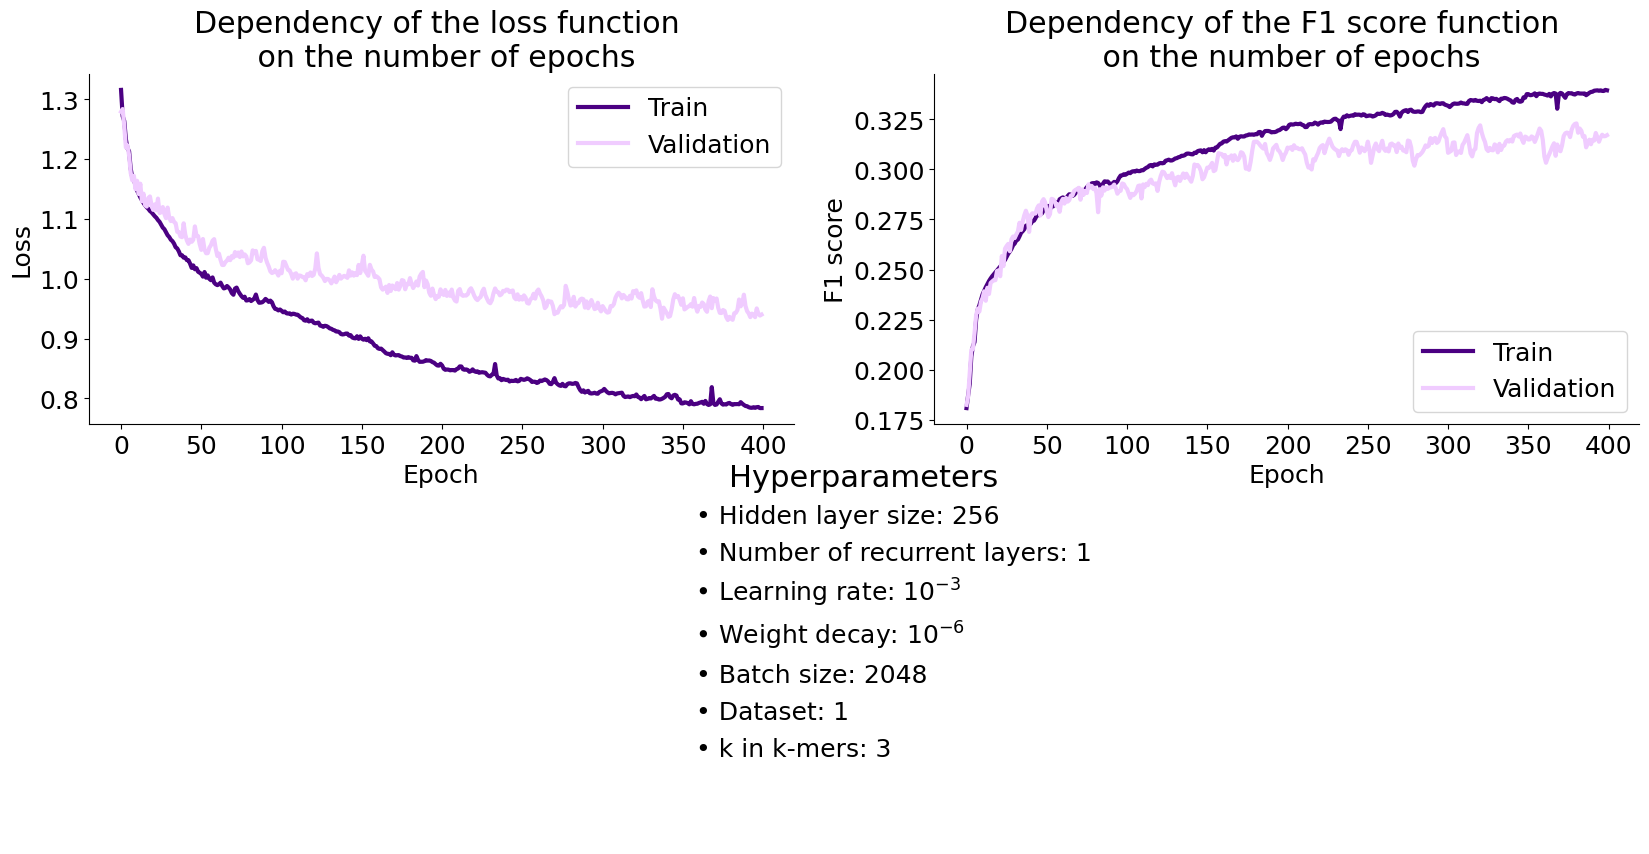

In [26]:
trials = os.listdir(os.path.join('..', 'results', run_name))
    
for trial in trials:
    try:
        show_dashboard(os.path.join(run_name, trial))
    except:
        pass

In [27]:
experiment_path = os.path.join('file://', os.path.abspath('..'), 'results', run_name)
analysis = ExperimentAnalysis(experiment_path)
results = analysis.results_df

#### Look at hyperparameter differences

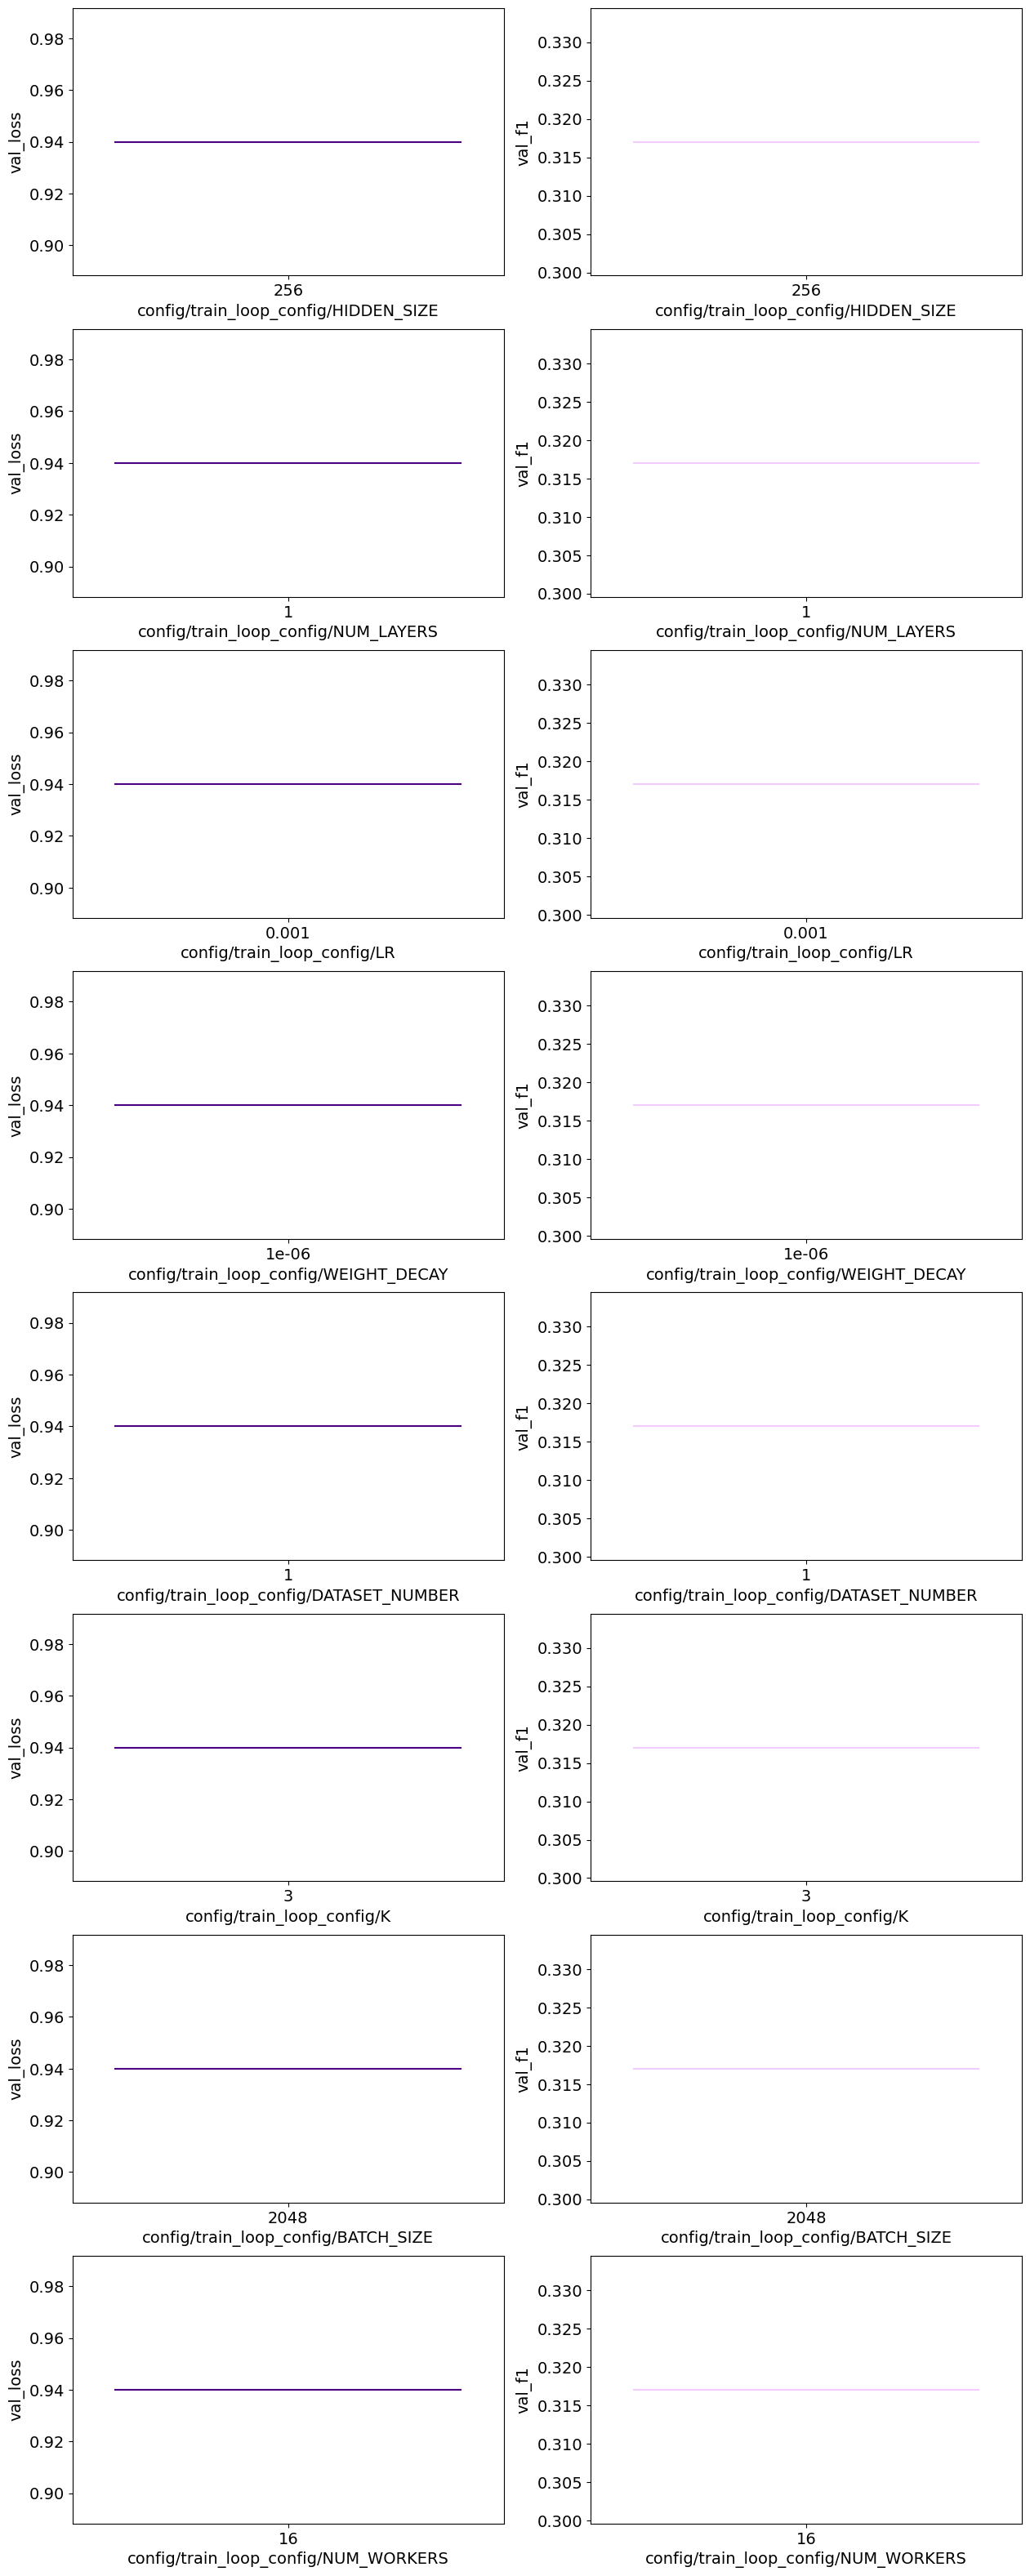

In [28]:
columns = list(results.columns[results.columns.get_loc('experiment_tag') + 1:])
num_plots = len(columns)
fig, axes = plt.subplots(nrows=num_plots, ncols=2, figsize=(15, 5 * num_plots))

for i, column in enumerate(columns):
    if num_plots > 1:
        sns.violinplot(
            data=results,
            x=column,
            y='val_loss',
            fill=False,
            color=INDIGO,
            ax=axes[i, 0]
        )
        sns.violinplot(
            data=results,
            x=column,
            y='val_f1',
            fill=False,
            color=LAVENDER,
            ax=axes[i, 1]
        )
    else:
        sns.violinplot(
            data=results,
            x=column,
            y='val_loss',
            fill=False,
            color=INDIGO,
            ax=axes[0]
        )
        sns.violinplot(
            data=results,
            x=column,
            y='val_f1',
            fill=False,
            color=LAVENDER,
            ax=axes[1]
        )

plt.show()

#### Get a dashboard of the best trial

Best trial path: results/test/trial_00000


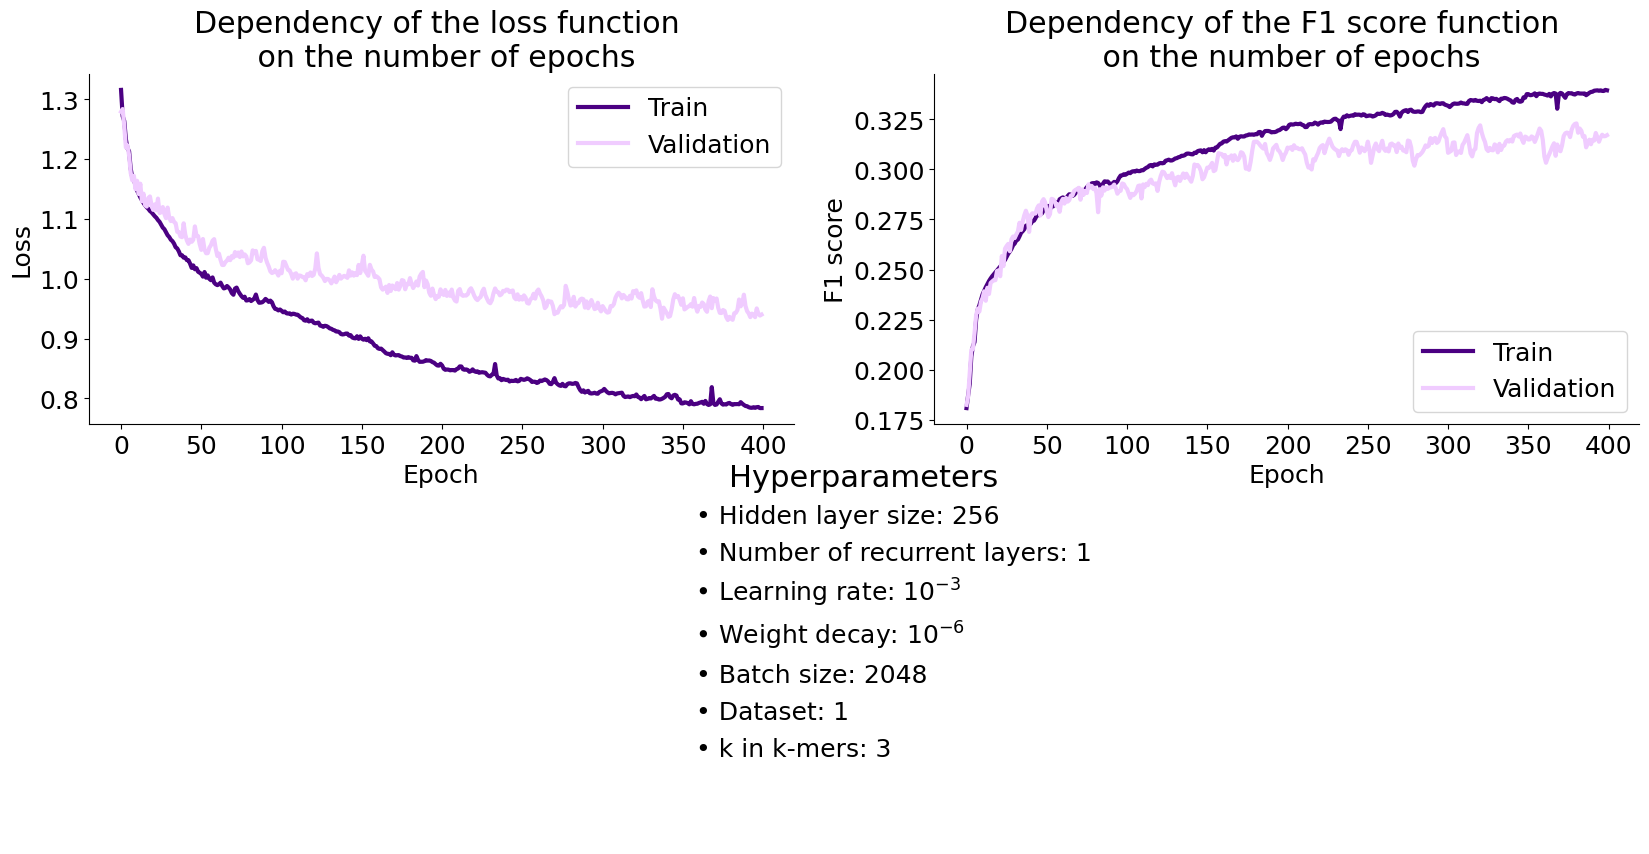

In [29]:
best_trial = analysis.get_best_trial(
    metric='val_f1',
    mode='max'
)

best_trial = str(best_trial).split('_')[-1]
best_trial = f'trial_{best_trial}'
path = os.path.join(run_name, best_trial)
print(f"Best trial path: {os.path.join('results', path)}")

try:
    show_dashboard(path)
except:
    pass

## Test the model

In [30]:
! python test.py

/home/v_sidorov/.conda/envs/DL_peak_calling/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python test.py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.33659592270851135    │
│         test_loss         │    0.8528208136558533     │
└───────────────────────────┴───────────────────────────┘
